# Estimation Methods for Identify Outliers using Rolling Statistics

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL

sns.set_context('talk')

## Rolling Mean

In [2]:
with open('./data/27-bulk_loaded_BDG690XU_202302031452_202302031549.json') as f:
    d = json.load(f)

df_ = pd.json_normalize(d)
df = df_.copy(deep=True)
df = df.rename(columns={"attributes.adc1":"adc", 'attributes.battery':'battery', 'attributes.power':'power','attributes.totalDistance':'totalDistance'}, errors='raise')
df['deviceTime'] = pd.to_datetime(df['deviceTime'])
df = df.set_index('deviceTime')
len(df)
df = df.loc[(df['adc'] >= 1540) & (df['adc'] <= 3460)]
#df.info()
#df

### Plot the Data

<AxesSubplot: xlabel='deviceTime'>

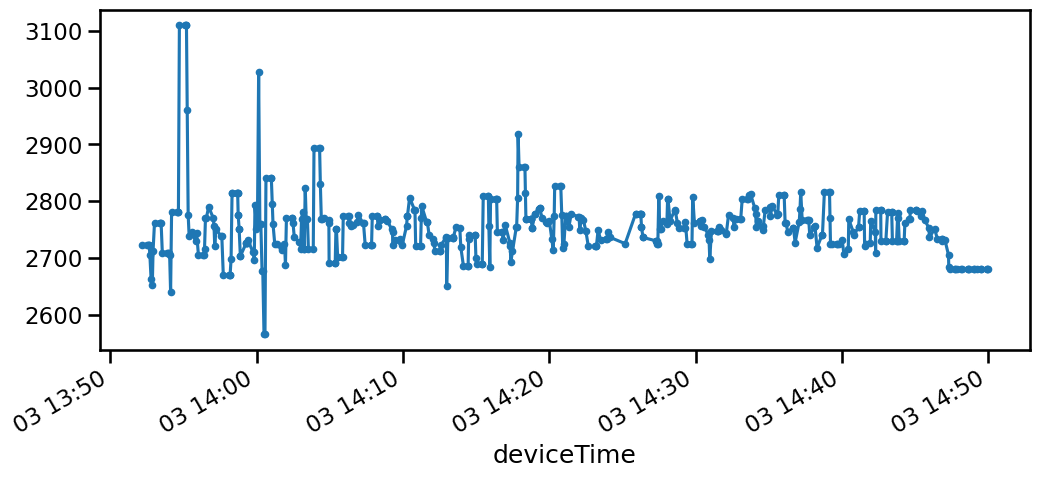

In [12]:
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="adc", marker=".", figsize=[12, 5], legend=None, ax=ax)
# ax.set_title("Retail Sales with outliers")
# ax.set_ylabel("Retail Sales")
# ax.set_xlabel("Time")

In [ ]:
df_ = df.copy()

In [52]:
# Compute yhat using a rolling mean and the rolling standard deviation which will be used as
# part of the threshold
df_rolling_stats = (
    df_["adc"]
    .rolling(
        window=199,  # A window of 13 is chosen to average over yearly seasonality
        center=True,  # Use a centered window for the mean
        min_periods=1,
    )  # Min periods set to 1 so that edge cases also have estimates
    .agg({"rolling_mean": "mean", "rolling_std": "std"})
)


df_[["rolling_mean", "rolling_std"]] = df_rolling_stats

# Apply the threshold criteria to identify an outlier
factor = 3
df_["is_outlier"] = np.abs(df_["adc"] - df_["rolling_mean"]) > factor * df_["rolling_std"]

df_[["adc","rolling_mean", "rolling_std", "is_outlier"]].head()

,adc,rolling_mean,rolling_std,is_outlier
deviceTime,,,,
2023-02-03 13:52:10+00:00,2723,2756.290000,94.627851,False
2023-02-03 13:52:31+00:00,2723,2756.405941,94.160733,False
2023-02-03 13:52:34+00:00,2723,2756.637255,93.722551,False
2023-02-03 13:52:37+00:00,2723,2756.242718,93.347912,False
2023-02-03 13:52:39+00:00,2723,2755.855769,92.977439,False


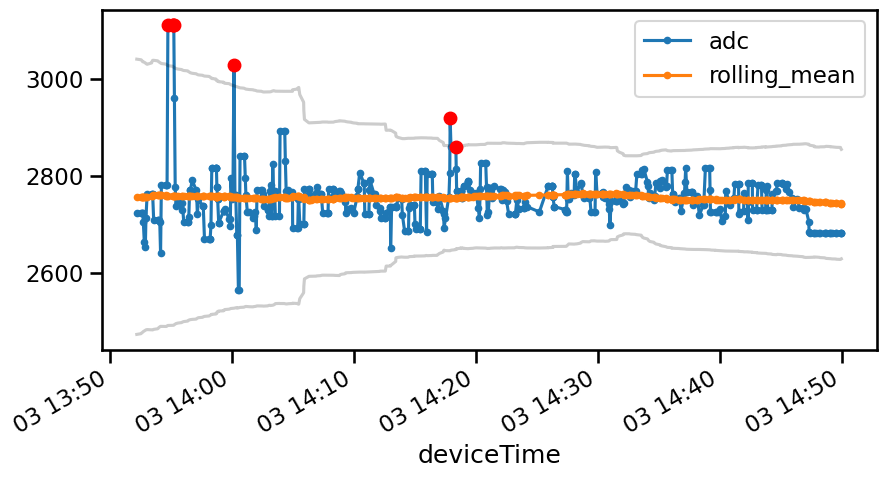

In [53]:
# Compute the upper and lower boundary of the threshold for plotting
df_["upper"] = df_["rolling_mean"] + factor * df_["rolling_std"]
df_["lower"] = df_["rolling_mean"] - factor * df_["rolling_std"]

# Plot
fig, ax = plt.subplots(figsize=[10, 5])
df_.plot(y=["adc", "rolling_mean"], marker=".", ax=ax)
df_.plot(
    y=["upper", "lower"], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None
)

# If any data points are identified as outlier, plot them
if df_["is_outlier"].any():
    df_["adc"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax, legend=None, linestyle=""
    )
    
# ax.set_title("Retail Sales deseasonalised with outliers")
# ax.set_ylabel("Retail Sales deseasonalised")
# ax.set_xlabel("Time")

## Rolling Median

In [48]:
median_absolute_deviation = lambda y: np.median(np.abs(y - np.median(y)))

In [49]:
df_ = df.copy()

In [54]:
df_rolling_stats = (
    df_["adc"]
    .rolling(
        window=199,  # A window of 13 is chosen to average over yearly seasonality
        center=True,  # Use a centered window for the mean
        min_periods=1,
    )  # Min periods set to 1 so that edge cases also have estimates
    .agg({"rolling_median": "median", "rolling_MAD": median_absolute_deviation})
)

df_[["rolling_median", "rolling_MAD"]] = df_rolling_stats

# Apply the threshold criteria to identify an outlier
factor = 3.5
df_["is_outlier"] = (
    np.abs(df_["adc"] - df_["rolling_median"]) > factor * df_["rolling_MAD"]
)

df_[["adc","rolling_median", "rolling_MAD", "is_outlier"]].head()

,adc,rolling_median,rolling_MAD,is_outlier
deviceTime,,,,
2023-02-03 13:52:10+00:00,2723,2737.5,32.5,False
2023-02-03 13:52:31+00:00,2723,2738.0,33.0,False
2023-02-03 13:52:34+00:00,2723,2738.0,33.0,False
2023-02-03 13:52:37+00:00,2723,2738.0,33.0,False
2023-02-03 13:52:39+00:00,2723,2737.5,32.5,False


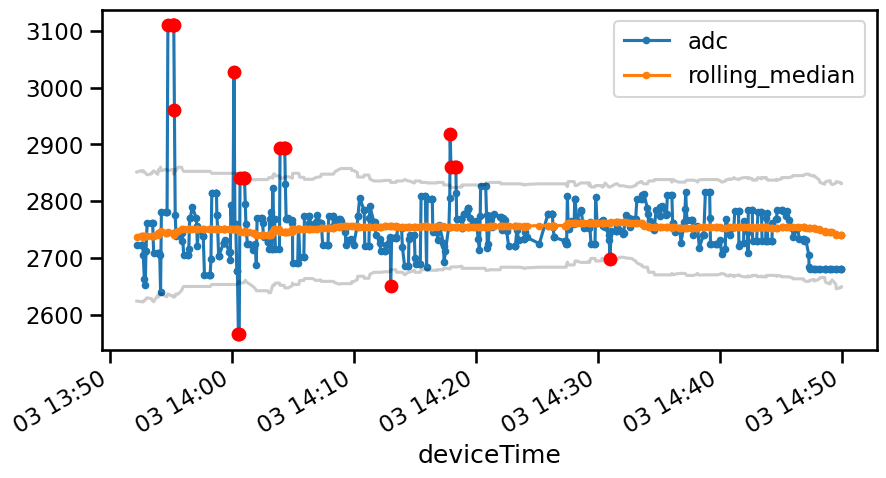

In [55]:
# Compute the upper and lower boundary of the threshold for plotting
df_["upper"] = df_["rolling_median"] + factor * df_["rolling_MAD"]
df_["lower"] = df_["rolling_median"] - factor * df_["rolling_MAD"]

# Plot
fig, ax = plt.subplots(figsize=[10, 5])
df_.plot(y=["adc", "rolling_median"], marker=".", ax=ax)
df_.plot(
    y=["upper", "lower"], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None
)

# If any data points are identified as outliers, plot them
if df_["is_outlier"].any():
    df_["adc"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax, legend=None, linestyle=""
    )
    
# ax.set_title("Retail Sales deseasonalised with outliers")
# ax.set_ylabel("Retail Sales deseasonalised")
# ax.set_xlabel("Time")